# SLIM MODEL
Since the KNN_Item_CF is the one that perfomed the best so far, now i'm trying a SLIM Model, which is basically the same algorithm but Machine Learning based. It uses the infos from the training data instead of some heuristic (such as cosine similarity ecc...)
https://notebook.community/trangel/Insight-Data-Science/general-docs/recommendation-validation/.ipynb_checkpoints/recommender_systems-validation-checkpoint

# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [5]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [6]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

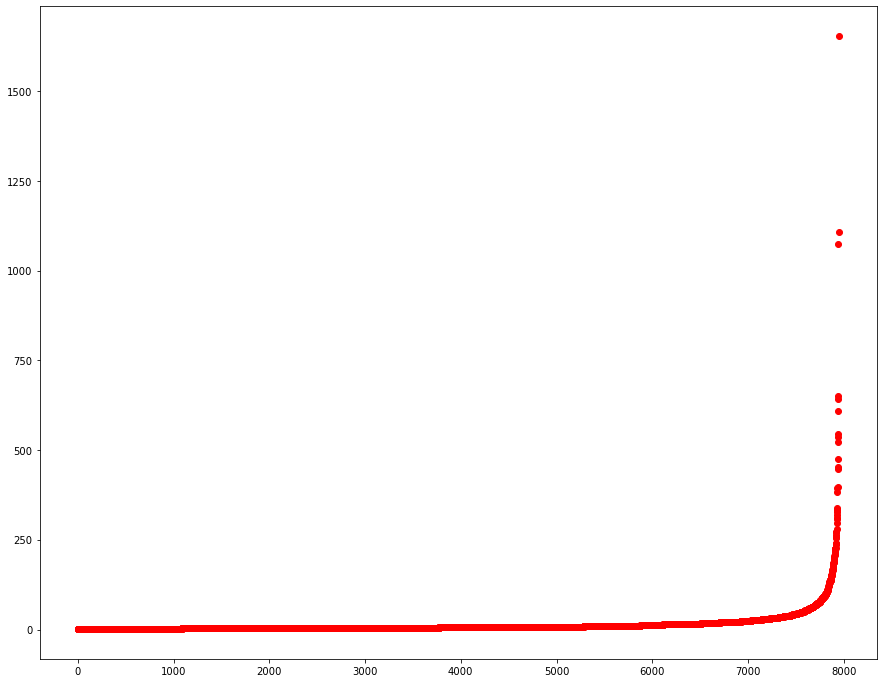

In [7]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

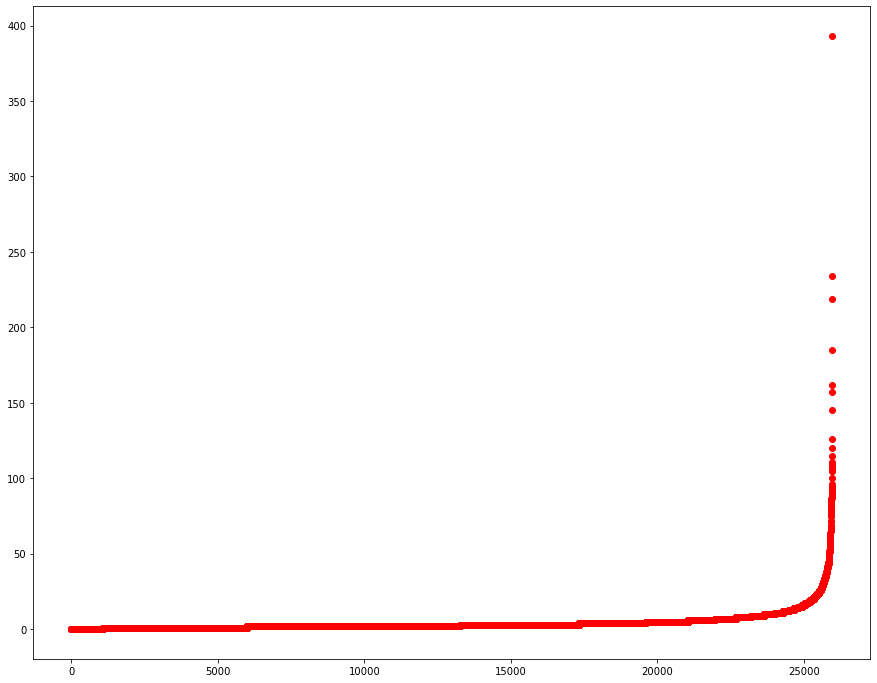

In [8]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [9]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [10]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [11]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)

SLIM_BPR_Recommender: URM Detected 24 (0.30 %) cold users.
SLIM_BPR_Recommender: URM Detected 2016 (7.76 %) cold items.


In [43]:
x_tick = []
collaborative_MAP = []

for topK in [200,300,400,450,500,600,700]:
    for lr in [1e-3,5e-3,1e-4,5e-4]:

        
        x_tick.append("topk {}, lr{}".format(topK, lr))

        
        recommender = SLIM_BPR_Cython(URM_train, recompile_cython=False)
    
        #remember to specify the positive threshold
        recommender.fit(epochs=200, batch_size=1000, sgd_mode='adagrad', learning_rate=lr, positive_threshold_BPR=1,  topK = topK, random_seed=1)
    
        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
    
        collaborative_MAP.append(result_dict[10]["MAP"])

SLIM_BPR_Recommender: URM Detected 24 (0.30 %) cold users.
SLIM_BPR_Recommender: URM Detected 2016 (7.76 %) cold items.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 3.73E-06. Sample per second: 9125
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.02 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 1.62E-05. Sample per second: 8911
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.04 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 3.27E-05. Sample per second: 8696
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 4.38E-05. Sample per second: 8501
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.09 sec
Processed 7947 ( 100.00% ) in 0.

Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 7.23E-04. Sample per second: 7921
SLIM_BPR_Recommender: Epoch 53 of 200. Elapsed time 1.15 sec
Processed 7947 ( 100.00% ) in 0.02 seconds. BPR loss is 7.42E-04. Sample per second: 340531
SLIM_BPR_Recommender: Epoch 54 of 200. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 7.31E-04. Sample per second: 175420
SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 1.20 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 7.78E-04. Sample per second: 118072
SLIM_BPR_Recommender: Epoch 56 of 200. Elapsed time 1.22 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 8.24E-04. Sample per second: 89006
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 1.24 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 8.10E-04. Sample per second: 71430
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 1.26 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 8.07E-04. Sample per second: 6

Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 1.50E-03. Sample per second: 37203
SLIM_BPR_Recommender: Epoch 107 of 200. Elapsed time 2.36 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 1.60E-03. Sample per second: 33874
SLIM_BPR_Recommender: Epoch 108 of 200. Elapsed time 2.38 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 1.55E-03. Sample per second: 31093
SLIM_BPR_Recommender: Epoch 109 of 200. Elapsed time 2.41 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 1.61E-03. Sample per second: 28734
SLIM_BPR_Recommender: Epoch 110 of 200. Elapsed time 2.43 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 1.60E-03. Sample per second: 26797
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 2.45 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 1.61E-03. Sample per second: 24949
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 2.47 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 1.62E-03. Sample per secon

SLIM_BPR_Recommender: Epoch 160 of 200. Elapsed time 3.52 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 2.25E-03. Sample per second: 20263
SLIM_BPR_Recommender: Epoch 161 of 200. Elapsed time 3.54 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 2.34E-03. Sample per second: 19187
SLIM_BPR_Recommender: Epoch 162 of 200. Elapsed time 3.57 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 2.33E-03. Sample per second: 18178
SLIM_BPR_Recommender: Epoch 163 of 200. Elapsed time 3.59 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 2.32E-03. Sample per second: 17346
SLIM_BPR_Recommender: Epoch 164 of 200. Elapsed time 3.61 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 2.42E-03. Sample per second: 16621
SLIM_BPR_Recommender: Epoch 165 of 200. Elapsed time 3.63 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 2.44E-03. Sample per second: 15922
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 3.65 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 3.27E-03. Sample per second: 50789
SLIM_BPR_Recommender: Epoch 11 of 200. Elapsed time 0.28 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 3.35E-03. Sample per second: 44735
SLIM_BPR_Recommender: Epoch 12 of 200. Elapsed time 0.30 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 4.22E-03. Sample per second: 39810
SLIM_BPR_Recommender: Epoch 13 of 200. Elapsed time 0.32 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 4.39E-03. Sample per second: 35700
SLIM_BPR_Recommender: Epoch 14 of 200. Elapsed time 0.34 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 4.40E-03. Sample per second: 32101
SLIM_BPR_Recommender: Epoch 15 of 200. Elapsed time 0.37 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 5.01E-03. Sample per second: 29592
SLIM_BPR_Recommender: Epoch 16 of 200. Elapsed time 0.39 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 5.24E-03. Sample per second: 274

Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 2.16E-02. Sample per second: 21295
SLIM_BPR_Recommender: Epoch 65 of 200. Elapsed time 1.49 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 2.24E-02. Sample per second: 20162
SLIM_BPR_Recommender: Epoch 66 of 200. Elapsed time 1.52 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 2.23E-02. Sample per second: 19051
SLIM_BPR_Recommender: Epoch 67 of 200. Elapsed time 1.54 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 2.38E-02. Sample per second: 17983
SLIM_BPR_Recommender: Epoch 68 of 200. Elapsed time 1.56 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 2.26E-02. Sample per second: 17136
SLIM_BPR_Recommender: Epoch 69 of 200. Elapsed time 1.59 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 2.30E-02. Sample per second: 16327
SLIM_BPR_Recommender: Epoch 70 of 200. Elapsed time 1.61 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 2.46E-02. Sample per second: 156

Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 3.89E-02. Sample per second: 12246
SLIM_BPR_Recommender: Epoch 119 of 200. Elapsed time 2.77 sec
Processed 7947 ( 100.00% ) in 0.67 seconds. BPR loss is 4.13E-02. Sample per second: 11855
SLIM_BPR_Recommender: Epoch 120 of 200. Elapsed time 2.79 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 4.16E-02. Sample per second: 11462
SLIM_BPR_Recommender: Epoch 121 of 200. Elapsed time 2.81 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 4.09E-02. Sample per second: 11141
SLIM_BPR_Recommender: Epoch 122 of 200. Elapsed time 2.84 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 4.18E-02. Sample per second: 10837
SLIM_BPR_Recommender: Epoch 123 of 200. Elapsed time 2.86 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 4.10E-02. Sample per second: 10522
SLIM_BPR_Recommender: Epoch 124 of 200. Elapsed time 2.88 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 4.23E-02. Sample per secon

Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 5.81E-02. Sample per second: 8708
SLIM_BPR_Recommender: Epoch 173 of 200. Elapsed time 4.03 sec
Processed 7947 ( 100.00% ) in 0.94 seconds. BPR loss is 5.86E-02. Sample per second: 8485
SLIM_BPR_Recommender: Epoch 174 of 200. Elapsed time 4.06 sec
Processed 7947 ( 100.00% ) in 0.96 seconds. BPR loss is 6.02E-02. Sample per second: 8256
SLIM_BPR_Recommender: Epoch 175 of 200. Elapsed time 4.08 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 5.98E-02. Sample per second: 8056
SLIM_BPR_Recommender: Epoch 176 of 200. Elapsed time 4.11 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 5.89E-02. Sample per second: 7880
SLIM_BPR_Recommender: Epoch 177 of 200. Elapsed time 4.13 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 5.95E-02. Sample per second: 229505
SLIM_BPR_Recommender: Epoch 178 of 200. Elapsed time 4.15 sec
Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 6.16E-02. Sample per second: 1

SLIM_BPR_Recommender: Epoch 23 of 200. Elapsed time 0.54 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 2.99E-06. Sample per second: 18302
SLIM_BPR_Recommender: Epoch 24 of 200. Elapsed time 0.56 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 3.17E-06. Sample per second: 17299
SLIM_BPR_Recommender: Epoch 25 of 200. Elapsed time 0.59 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 3.47E-06. Sample per second: 16509
SLIM_BPR_Recommender: Epoch 26 of 200. Elapsed time 0.61 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 3.44E-06. Sample per second: 15757
SLIM_BPR_Recommender: Epoch 27 of 200. Elapsed time 0.63 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 3.69E-06. Sample per second: 15070
SLIM_BPR_Recommender: Epoch 28 of 200. Elapsed time 0.66 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 3.76E-06. Sample per second: 14415
SLIM_BPR_Recommender: Epoch 29 of 200. Elapsed time 0.68 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 77 of 200. Elapsed time 1.89 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 1.10E-05. Sample per second: 10142
SLIM_BPR_Recommender: Epoch 78 of 200. Elapsed time 1.91 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 1.15E-05. Sample per second: 9878
SLIM_BPR_Recommender: Epoch 79 of 200. Elapsed time 1.93 sec
Processed 7947 ( 100.00% ) in 0.83 seconds. BPR loss is 1.19E-05. Sample per second: 9615
SLIM_BPR_Recommender: Epoch 80 of 200. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 1.11E-05. Sample per second: 9355
SLIM_BPR_Recommender: Epoch 81 of 200. Elapsed time 1.98 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 1.15E-05. Sample per second: 9129
SLIM_BPR_Recommender: Epoch 82 of 200. Elapsed time 2.00 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 1.15E-05. Sample per second: 8934
SLIM_BPR_Recommender: Epoch 83 of 200. Elapsed time 2.02 sec
Processed 7947 ( 100.00% ) in 0.

SLIM_BPR_Recommender: Epoch 131 of 200. Elapsed time 3.11 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.91E-05. Sample per second: 7897
SLIM_BPR_Recommender: Epoch 132 of 200. Elapsed time 3.13 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 2.01E-05. Sample per second: 279421
SLIM_BPR_Recommender: Epoch 133 of 200. Elapsed time 3.15 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 1.92E-05. Sample per second: 154539
SLIM_BPR_Recommender: Epoch 134 of 200. Elapsed time 3.18 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 2.02E-05. Sample per second: 111284
SLIM_BPR_Recommender: Epoch 135 of 200. Elapsed time 3.20 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 2.00E-05. Sample per second: 86025
SLIM_BPR_Recommender: Epoch 136 of 200. Elapsed time 3.22 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.00E-05. Sample per second: 69565
SLIM_BPR_Recommender: Epoch 137 of 200. Elapsed time 3.24 sec
Processed 7947 ( 1

SLIM_BPR_Recommender: Epoch 185 of 200. Elapsed time 4.38 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 2.75E-05. Sample per second: 29163
SLIM_BPR_Recommender: Epoch 186 of 200. Elapsed time 4.40 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 2.72E-05. Sample per second: 26715
SLIM_BPR_Recommender: Epoch 187 of 200. Elapsed time 4.42 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 2.70E-05. Sample per second: 25032
SLIM_BPR_Recommender: Epoch 188 of 200. Elapsed time 4.44 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 2.84E-05. Sample per second: 23411
SLIM_BPR_Recommender: Epoch 189 of 200. Elapsed time 4.47 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 2.82E-05. Sample per second: 21927
SLIM_BPR_Recommender: Epoch 190 of 200. Elapsed time 4.49 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 2.80E-05. Sample per second: 20458
SLIM_BPR_Recommender: Epoch 191 of 200. Elapsed time 4.52 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 1.28E-04. Sample per second: 76149
SLIM_BPR_Recommender: Epoch 36 of 200. Elapsed time 0.90 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 1.26E-04. Sample per second: 61448
SLIM_BPR_Recommender: Epoch 37 of 200. Elapsed time 0.92 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 1.29E-04. Sample per second: 50191
SLIM_BPR_Recommender: Epoch 38 of 200. Elapsed time 0.95 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 1.38E-04. Sample per second: 43592
SLIM_BPR_Recommender: Epoch 39 of 200. Elapsed time 0.98 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 1.35E-04. Sample per second: 38901
SLIM_BPR_Recommender: Epoch 40 of 200. Elapsed time 1.00 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 1.46E-04. Sample per second: 34362
SLIM_BPR_Recommender: Epoch 41 of 200. Elapsed time 1.03 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 1.49E-04. Sample per second: 307

Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 3.30E-04. Sample per second: 16860
SLIM_BPR_Recommender: Epoch 90 of 200. Elapsed time 2.27 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 3.25E-04. Sample per second: 16047
SLIM_BPR_Recommender: Epoch 91 of 200. Elapsed time 2.29 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 3.43E-04. Sample per second: 15306
SLIM_BPR_Recommender: Epoch 92 of 200. Elapsed time 2.31 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 3.28E-04. Sample per second: 14576
SLIM_BPR_Recommender: Epoch 93 of 200. Elapsed time 2.34 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 3.33E-04. Sample per second: 13963
SLIM_BPR_Recommender: Epoch 94 of 200. Elapsed time 2.36 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 3.41E-04. Sample per second: 13488
SLIM_BPR_Recommender: Epoch 95 of 200. Elapsed time 2.38 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 3.43E-04. Sample per second: 129

Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 5.24E-04. Sample per second: 10354
SLIM_BPR_Recommender: Epoch 144 of 200. Elapsed time 3.56 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 5.51E-04. Sample per second: 9997
SLIM_BPR_Recommender: Epoch 145 of 200. Elapsed time 3.59 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 5.32E-04. Sample per second: 9716
SLIM_BPR_Recommender: Epoch 146 of 200. Elapsed time 3.61 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 5.25E-04. Sample per second: 9473
SLIM_BPR_Recommender: Epoch 147 of 200. Elapsed time 3.63 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 5.48E-04. Sample per second: 9231
SLIM_BPR_Recommender: Epoch 148 of 200. Elapsed time 3.65 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 5.38E-04. Sample per second: 9001
SLIM_BPR_Recommender: Epoch 149 of 200. Elapsed time 3.68 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 5.55E-04. Sample per second: 87

Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 7.30E-04. Sample per second: 68131
SLIM_BPR_Recommender: Epoch 198 of 200. Elapsed time 4.91 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 7.05E-04. Sample per second: 56108
SLIM_BPR_Recommender: Epoch 199 of 200. Elapsed time 4.94 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 7.52E-04. Sample per second: 47986
SLIM_BPR_Recommender: Epoch 200 of 200. Elapsed time 4.96 sec
SLIM_BPR_Recommender: Terminating at epoch 200. Elapsed time 42.14 sec
Deallocating Cython objects
EvaluatorHoldout: Processed 4925 ( 100.00% ) in 3.55 sec. Users per second: 1387
SLIM_BPR_Recommender: URM Detected 24 (0.30 %) cold users.
SLIM_BPR_Recommender: URM Detected 2016 (7.76 %) cold items.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense m

SLIM_BPR_Recommender: Epoch 48 of 200. Elapsed time 1.24 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 6.69E-04. Sample per second: 9257
SLIM_BPR_Recommender: Epoch 49 of 200. Elapsed time 1.27 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 7.20E-04. Sample per second: 8995
SLIM_BPR_Recommender: Epoch 50 of 200. Elapsed time 1.29 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 6.90E-04. Sample per second: 8788
SLIM_BPR_Recommender: Epoch 51 of 200. Elapsed time 1.31 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 7.26E-04. Sample per second: 8598
SLIM_BPR_Recommender: Epoch 52 of 200. Elapsed time 1.34 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 7.23E-04. Sample per second: 8354
SLIM_BPR_Recommender: Epoch 53 of 200. Elapsed time 1.36 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 7.42E-04. Sample per second: 8144
SLIM_BPR_Recommender: Epoch 54 of 200. Elapsed time 1.39 sec
Processed 7947 ( 100.00% ) in 1.0

SLIM_BPR_Recommender: Epoch 102 of 200. Elapsed time 2.58 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 1.52E-03. Sample per second: 41561
SLIM_BPR_Recommender: Epoch 103 of 200. Elapsed time 2.60 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 1.46E-03. Sample per second: 36757
SLIM_BPR_Recommender: Epoch 104 of 200. Elapsed time 2.63 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 1.50E-03. Sample per second: 33366
SLIM_BPR_Recommender: Epoch 105 of 200. Elapsed time 2.65 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 1.51E-03. Sample per second: 30666
SLIM_BPR_Recommender: Epoch 106 of 200. Elapsed time 2.67 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 1.50E-03. Sample per second: 28079
SLIM_BPR_Recommender: Epoch 107 of 200. Elapsed time 2.69 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 1.60E-03. Sample per second: 26109
SLIM_BPR_Recommender: Epoch 108 of 200. Elapsed time 2.72 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 156 of 200. Elapsed time 4.07 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 2.25E-03. Sample per second: 11447
SLIM_BPR_Recommender: Epoch 157 of 200. Elapsed time 4.11 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 2.38E-03. Sample per second: 10883
SLIM_BPR_Recommender: Epoch 158 of 200. Elapsed time 4.14 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 2.28E-03. Sample per second: 10509
SLIM_BPR_Recommender: Epoch 159 of 200. Elapsed time 4.17 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 2.29E-03. Sample per second: 10147
SLIM_BPR_Recommender: Epoch 160 of 200. Elapsed time 4.20 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 2.25E-03. Sample per second: 9773
SLIM_BPR_Recommender: Epoch 161 of 200. Elapsed time 4.23 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 2.34E-03. Sample per second: 9359
SLIM_BPR_Recommender: Epoch 162 of 200. Elapsed time 4.26 sec
Processed 7947 ( 100.0

Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 2.01E-03. Sample per second: 9420
SLIM_BPR_Recommender: Epoch 7 of 200. Elapsed time 0.25 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 2.11E-03. Sample per second: 9055
SLIM_BPR_Recommender: Epoch 8 of 200. Elapsed time 0.28 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 2.54E-03. Sample per second: 8727
SLIM_BPR_Recommender: Epoch 9 of 200. Elapsed time 0.31 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 2.99E-03. Sample per second: 8351
SLIM_BPR_Recommender: Epoch 10 of 200. Elapsed time 0.35 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 3.27E-03. Sample per second: 8007
SLIM_BPR_Recommender: Epoch 11 of 200. Elapsed time 0.40 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 3.35E-03. Sample per second: 7764
SLIM_BPR_Recommender: Epoch 12 of 200. Elapsed time 0.43 sec
Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 4.22E-03. Sample per second: 137872
SLIM_

SLIM_BPR_Recommender: Epoch 61 of 200. Elapsed time 3.04 sec
Processed 7947 ( 100.00% ) in 0.70 seconds. BPR loss is 2.08E-02. Sample per second: 11390
SLIM_BPR_Recommender: Epoch 62 of 200. Elapsed time 3.10 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 2.07E-02. Sample per second: 10502
SLIM_BPR_Recommender: Epoch 63 of 200. Elapsed time 3.16 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 2.13E-02. Sample per second: 9779
SLIM_BPR_Recommender: Epoch 64 of 200. Elapsed time 3.22 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 2.16E-02. Sample per second: 9299
SLIM_BPR_Recommender: Epoch 65 of 200. Elapsed time 3.26 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 2.24E-02. Sample per second: 8913
SLIM_BPR_Recommender: Epoch 66 of 200. Elapsed time 3.29 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 2.23E-02. Sample per second: 8577
SLIM_BPR_Recommender: Epoch 67 of 200. Elapsed time 3.33 sec
Processed 7947 ( 100.00% ) in 0

SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 4.66 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 3.87E-02. Sample per second: 27233
SLIM_BPR_Recommender: Epoch 116 of 200. Elapsed time 4.69 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 3.92E-02. Sample per second: 24696
SLIM_BPR_Recommender: Epoch 117 of 200. Elapsed time 4.72 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 3.86E-02. Sample per second: 22916
SLIM_BPR_Recommender: Epoch 118 of 200. Elapsed time 4.75 sec
Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 3.89E-02. Sample per second: 21262
SLIM_BPR_Recommender: Epoch 119 of 200. Elapsed time 4.77 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 4.13E-02. Sample per second: 19880
SLIM_BPR_Recommender: Epoch 120 of 200. Elapsed time 4.80 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 4.16E-02. Sample per second: 18536
SLIM_BPR_Recommender: Epoch 121 of 200. Elapsed time 4.83 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 6.15 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 5.62E-02. Sample per second: 10340
SLIM_BPR_Recommender: Epoch 170 of 200. Elapsed time 6.17 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 5.90E-02. Sample per second: 9964
SLIM_BPR_Recommender: Epoch 171 of 200. Elapsed time 6.20 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 5.93E-02. Sample per second: 9650
SLIM_BPR_Recommender: Epoch 172 of 200. Elapsed time 6.23 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 5.81E-02. Sample per second: 9399
SLIM_BPR_Recommender: Epoch 173 of 200. Elapsed time 6.25 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 5.86E-02. Sample per second: 9150
SLIM_BPR_Recommender: Epoch 174 of 200. Elapsed time 6.27 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 6.02E-02. Sample per second: 8874
SLIM_BPR_Recommender: Epoch 175 of 200. Elapsed time 6.30 sec
Processed 7947 ( 100.00% 

Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 2.72E-06. Sample per second: 12682
SLIM_BPR_Recommender: Epoch 20 of 200. Elapsed time 0.54 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 2.77E-06. Sample per second: 12048
SLIM_BPR_Recommender: Epoch 21 of 200. Elapsed time 0.58 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 2.97E-06. Sample per second: 11491
SLIM_BPR_Recommender: Epoch 22 of 200. Elapsed time 0.61 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 3.74E-06. Sample per second: 11044
SLIM_BPR_Recommender: Epoch 23 of 200. Elapsed time 0.64 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 2.99E-06. Sample per second: 10702
SLIM_BPR_Recommender: Epoch 24 of 200. Elapsed time 0.66 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 3.17E-06. Sample per second: 10327
SLIM_BPR_Recommender: Epoch 25 of 200. Elapsed time 0.69 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 3.47E-06. Sample per second: 100

Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 1.02E-05. Sample per second: 129005
SLIM_BPR_Recommender: Epoch 74 of 200. Elapsed time 1.98 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 1.06E-05. Sample per second: 90859
SLIM_BPR_Recommender: Epoch 75 of 200. Elapsed time 2.01 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 1.08E-05. Sample per second: 70042
SLIM_BPR_Recommender: Epoch 76 of 200. Elapsed time 2.03 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 1.11E-05. Sample per second: 56227
SLIM_BPR_Recommender: Epoch 77 of 200. Elapsed time 2.06 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 1.10E-05. Sample per second: 47791
SLIM_BPR_Recommender: Epoch 78 of 200. Elapsed time 2.09 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 1.15E-05. Sample per second: 40908
SLIM_BPR_Recommender: Epoch 79 of 200. Elapsed time 2.11 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 1.19E-05. Sample per second: 35

Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 1.92E-05. Sample per second: 15704
SLIM_BPR_Recommender: Epoch 128 of 200. Elapsed time 3.43 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 1.84E-05. Sample per second: 14909
SLIM_BPR_Recommender: Epoch 129 of 200. Elapsed time 3.45 sec
Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 1.85E-05. Sample per second: 14190
SLIM_BPR_Recommender: Epoch 130 of 200. Elapsed time 3.48 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 1.92E-05. Sample per second: 13562
SLIM_BPR_Recommender: Epoch 131 of 200. Elapsed time 3.50 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 1.91E-05. Sample per second: 12986
SLIM_BPR_Recommender: Epoch 132 of 200. Elapsed time 3.53 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 2.01E-05. Sample per second: 12129
SLIM_BPR_Recommender: Epoch 133 of 200. Elapsed time 3.57 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 1.92E-05. Sample per secon

Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 2.68E-05. Sample per second: 305334
SLIM_BPR_Recommender: Epoch 182 of 200. Elapsed time 4.95 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 2.72E-05. Sample per second: 155787
SLIM_BPR_Recommender: Epoch 183 of 200. Elapsed time 4.97 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 2.73E-05. Sample per second: 101894
SLIM_BPR_Recommender: Epoch 184 of 200. Elapsed time 5.00 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.77E-05. Sample per second: 70347
SLIM_BPR_Recommender: Epoch 185 of 200. Elapsed time 5.03 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.75E-05. Sample per second: 56389
SLIM_BPR_Recommender: Epoch 186 of 200. Elapsed time 5.06 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 2.72E-05. Sample per second: 47611
SLIM_BPR_Recommender: Epoch 187 of 200. Elapsed time 5.08 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 2.70E-05. Sample per se

SLIM_BPR_Recommender: Epoch 32 of 200. Elapsed time 0.77 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 1.18E-04. Sample per second: 14392
SLIM_BPR_Recommender: Epoch 33 of 200. Elapsed time 0.80 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 1.12E-04. Sample per second: 13817
SLIM_BPR_Recommender: Epoch 34 of 200. Elapsed time 0.82 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 1.19E-04. Sample per second: 13219
SLIM_BPR_Recommender: Epoch 35 of 200. Elapsed time 0.85 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 1.28E-04. Sample per second: 12473
SLIM_BPR_Recommender: Epoch 36 of 200. Elapsed time 0.88 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 1.26E-04. Sample per second: 12002
SLIM_BPR_Recommender: Epoch 37 of 200. Elapsed time 0.91 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 1.29E-04. Sample per second: 11566
SLIM_BPR_Recommender: Epoch 38 of 200. Elapsed time 0.93 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 86 of 200. Elapsed time 2.08 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 3.04E-04. Sample per second: 9237
SLIM_BPR_Recommender: Epoch 87 of 200. Elapsed time 2.10 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 3.08E-04. Sample per second: 9007
SLIM_BPR_Recommender: Epoch 88 of 200. Elapsed time 2.13 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 3.09E-04. Sample per second: 8749
SLIM_BPR_Recommender: Epoch 89 of 200. Elapsed time 2.15 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 3.30E-04. Sample per second: 8531
SLIM_BPR_Recommender: Epoch 90 of 200. Elapsed time 2.18 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 3.25E-04. Sample per second: 8335
SLIM_BPR_Recommender: Epoch 91 of 200. Elapsed time 2.20 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 3.43E-04. Sample per second: 8155
SLIM_BPR_Recommender: Epoch 92 of 200. Elapsed time 2.22 sec
Processed 7947 ( 100.00% ) in 0.9

Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 5.24E-04. Sample per second: 75955
SLIM_BPR_Recommender: Epoch 140 of 200. Elapsed time 3.36 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 5.10E-04. Sample per second: 51056
SLIM_BPR_Recommender: Epoch 141 of 200. Elapsed time 3.40 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 5.05E-04. Sample per second: 44978
SLIM_BPR_Recommender: Epoch 142 of 200. Elapsed time 3.42 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 5.11E-04. Sample per second: 38430
SLIM_BPR_Recommender: Epoch 143 of 200. Elapsed time 3.45 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 5.24E-04. Sample per second: 35188
SLIM_BPR_Recommender: Epoch 144 of 200. Elapsed time 3.47 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 5.51E-04. Sample per second: 31221
SLIM_BPR_Recommender: Epoch 145 of 200. Elapsed time 3.50 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 5.32E-04. Sample per secon

SLIM_BPR_Recommender: Epoch 193 of 200. Elapsed time 4.64 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 7.29E-04. Sample per second: 18973
SLIM_BPR_Recommender: Epoch 194 of 200. Elapsed time 4.67 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 7.16E-04. Sample per second: 17666
SLIM_BPR_Recommender: Epoch 195 of 200. Elapsed time 4.70 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 7.29E-04. Sample per second: 16772
SLIM_BPR_Recommender: Epoch 196 of 200. Elapsed time 4.72 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 7.26E-04. Sample per second: 15932
SLIM_BPR_Recommender: Epoch 197 of 200. Elapsed time 4.75 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 7.30E-04. Sample per second: 15230
SLIM_BPR_Recommender: Epoch 198 of 200. Elapsed time 4.77 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 7.05E-04. Sample per second: 14696
SLIM_BPR_Recommender: Epoch 199 of 200. Elapsed time 4.79 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 5.85E-04. Sample per second: 27164
SLIM_BPR_Recommender: Epoch 44 of 200. Elapsed time 1.09 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 6.01E-04. Sample per second: 25105
SLIM_BPR_Recommender: Epoch 45 of 200. Elapsed time 1.12 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 6.22E-04. Sample per second: 23000
SLIM_BPR_Recommender: Epoch 46 of 200. Elapsed time 1.14 sec
Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 6.17E-04. Sample per second: 21335
SLIM_BPR_Recommender: Epoch 47 of 200. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 6.70E-04. Sample per second: 19994
SLIM_BPR_Recommender: Epoch 48 of 200. Elapsed time 1.19 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 6.69E-04. Sample per second: 18856
SLIM_BPR_Recommender: Epoch 49 of 200. Elapsed time 1.22 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 7.20E-04. Sample per second: 178

Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 1.35E-03. Sample per second: 10405
SLIM_BPR_Recommender: Epoch 98 of 200. Elapsed time 2.56 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 1.38E-03. Sample per second: 10050
SLIM_BPR_Recommender: Epoch 99 of 200. Elapsed time 2.59 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 1.42E-03. Sample per second: 9762
SLIM_BPR_Recommender: Epoch 100 of 200. Elapsed time 2.61 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 1.45E-03. Sample per second: 9483
SLIM_BPR_Recommender: Epoch 101 of 200. Elapsed time 2.64 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 1.43E-03. Sample per second: 9219
SLIM_BPR_Recommender: Epoch 102 of 200. Elapsed time 2.66 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 1.52E-03. Sample per second: 8988
SLIM_BPR_Recommender: Epoch 103 of 200. Elapsed time 2.68 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 1.46E-03. Sample per second: 877

Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 2.16E-03. Sample per second: 83404
SLIM_BPR_Recommender: Epoch 152 of 200. Elapsed time 3.89 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 2.20E-03. Sample per second: 65008
SLIM_BPR_Recommender: Epoch 153 of 200. Elapsed time 3.92 sec
Processed 7947 ( 100.00% ) in 0.15 seconds. BPR loss is 2.17E-03. Sample per second: 54720
SLIM_BPR_Recommender: Epoch 154 of 200. Elapsed time 3.94 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 2.20E-03. Sample per second: 47239
SLIM_BPR_Recommender: Epoch 155 of 200. Elapsed time 3.97 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 2.22E-03. Sample per second: 41134
SLIM_BPR_Recommender: Epoch 156 of 200. Elapsed time 3.99 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 2.25E-03. Sample per second: 36287
SLIM_BPR_Recommender: Epoch 157 of 200. Elapsed time 4.02 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 2.38E-03. Sample per secon

SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.08 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 8.16E-04. Sample per second: 10262
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.13 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 1.09E-03. Sample per second: 9783
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.16 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 1.19E-03. Sample per second: 9412
SLIM_BPR_Recommender: Epoch 5 of 200. Elapsed time 0.19 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 1.59E-03. Sample per second: 9120
SLIM_BPR_Recommender: Epoch 6 of 200. Elapsed time 0.22 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 2.01E-03. Sample per second: 8847
SLIM_BPR_Recommender: Epoch 7 of 200. Elapsed time 0.25 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 2.11E-03. Sample per second: 8579
SLIM_BPR_Recommender: Epoch 8 of 200. Elapsed time 0.28 sec
Processed 7947 ( 100.00% ) in 0.96 seco

Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 1.98E-02. Sample per second: 33409
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 1.59 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 1.95E-02. Sample per second: 29561
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 1.62 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 1.94E-02. Sample per second: 26864
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 1.65 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 2.04E-02. Sample per second: 24543
SLIM_BPR_Recommender: Epoch 60 of 200. Elapsed time 1.67 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 1.95E-02. Sample per second: 22785
SLIM_BPR_Recommender: Epoch 61 of 200. Elapsed time 1.70 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 2.08E-02. Sample per second: 21037
SLIM_BPR_Recommender: Epoch 62 of 200. Elapsed time 1.73 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 2.07E-02. Sample per second: 196

Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 3.77E-02. Sample per second: 10727
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 3.09 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 3.81E-02. Sample per second: 10390
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 3.12 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 3.82E-02. Sample per second: 10043
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 3.14 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 3.85E-02. Sample per second: 9700
SLIM_BPR_Recommender: Epoch 114 of 200. Elapsed time 3.17 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 3.80E-02. Sample per second: 9228
SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 3.21 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 3.87E-02. Sample per second: 8828
SLIM_BPR_Recommender: Epoch 116 of 200. Elapsed time 3.25 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 3.92E-02. Sample per second: 

Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 5.65E-02. Sample per second: 20514
SLIM_BPR_Recommender: Epoch 165 of 200. Elapsed time 4.74 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 5.69E-02. Sample per second: 19365
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 4.76 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 5.69E-02. Sample per second: 18213
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 4.82 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 5.71E-02. Sample per second: 14986
SLIM_BPR_Recommender: Epoch 168 of 200. Elapsed time 4.88 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 5.77E-02. Sample per second: 13985
SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 4.92 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 5.62E-02. Sample per second: 13218
SLIM_BPR_Recommender: Epoch 170 of 200. Elapsed time 4.95 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 5.90E-02. Sample per secon

SLIM_BPR_Recommender: Epoch 15 of 200. Elapsed time 0.45 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 2.04E-06. Sample per second: 12499
SLIM_BPR_Recommender: Epoch 16 of 200. Elapsed time 0.49 sec
Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 2.14E-06. Sample per second: 11639
SLIM_BPR_Recommender: Epoch 17 of 200. Elapsed time 0.54 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 2.24E-06. Sample per second: 11041
SLIM_BPR_Recommender: Epoch 18 of 200. Elapsed time 0.57 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 2.45E-06. Sample per second: 10530
SLIM_BPR_Recommender: Epoch 19 of 200. Elapsed time 0.61 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 2.72E-06. Sample per second: 9963
SLIM_BPR_Recommender: Epoch 20 of 200. Elapsed time 0.65 sec
Processed 7947 ( 100.00% ) in 0.83 seconds. BPR loss is 2.77E-06. Sample per second: 9614
SLIM_BPR_Recommender: Epoch 21 of 200. Elapsed time 0.68 sec
Processed 7947 ( 100.00% ) in

SLIM_BPR_Recommender: Epoch 69 of 200. Elapsed time 1.94 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 9.71E-06. Sample per second: 67033
SLIM_BPR_Recommender: Epoch 70 of 200. Elapsed time 1.97 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 1.04E-05. Sample per second: 55747
SLIM_BPR_Recommender: Epoch 71 of 200. Elapsed time 1.99 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 1.03E-05. Sample per second: 47719
SLIM_BPR_Recommender: Epoch 72 of 200. Elapsed time 2.02 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 1.05E-05. Sample per second: 41494
SLIM_BPR_Recommender: Epoch 73 of 200. Elapsed time 2.05 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 1.02E-05. Sample per second: 35878
SLIM_BPR_Recommender: Epoch 74 of 200. Elapsed time 2.08 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 1.06E-05. Sample per second: 32114
SLIM_BPR_Recommender: Epoch 75 of 200. Elapsed time 2.10 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 123 of 200. Elapsed time 3.33 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 1.76E-05. Sample per second: 15798
SLIM_BPR_Recommender: Epoch 124 of 200. Elapsed time 3.36 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 1.82E-05. Sample per second: 15022
SLIM_BPR_Recommender: Epoch 125 of 200. Elapsed time 3.38 sec
Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 1.94E-05. Sample per second: 14318
SLIM_BPR_Recommender: Epoch 126 of 200. Elapsed time 3.41 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 1.89E-05. Sample per second: 13725
SLIM_BPR_Recommender: Epoch 127 of 200. Elapsed time 3.43 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 1.92E-05. Sample per second: 13157
SLIM_BPR_Recommender: Epoch 128 of 200. Elapsed time 3.46 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 1.84E-05. Sample per second: 12695
SLIM_BPR_Recommender: Epoch 129 of 200. Elapsed time 3.48 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 177 of 200. Elapsed time 4.89 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 2.60E-05. Sample per second: 147118
SLIM_BPR_Recommender: Epoch 178 of 200. Elapsed time 4.91 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 2.70E-05. Sample per second: 99333
SLIM_BPR_Recommender: Epoch 179 of 200. Elapsed time 4.93 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.75E-05. Sample per second: 71615
SLIM_BPR_Recommender: Epoch 180 of 200. Elapsed time 4.96 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.65E-05. Sample per second: 56786
SLIM_BPR_Recommender: Epoch 181 of 200. Elapsed time 4.99 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 2.68E-05. Sample per second: 48180
SLIM_BPR_Recommender: Epoch 182 of 200. Elapsed time 5.02 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 2.72E-05. Sample per second: 41196
SLIM_BPR_Recommender: Epoch 183 of 200. Elapsed time 5.05 sec
Processed 7947 ( 10

Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 9.20E-05. Sample per second: 12025
SLIM_BPR_Recommender: Epoch 28 of 200. Elapsed time 0.74 sec
Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 9.39E-05. Sample per second: 11621
SLIM_BPR_Recommender: Epoch 29 of 200. Elapsed time 0.76 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 1.00E-04. Sample per second: 11266
SLIM_BPR_Recommender: Epoch 30 of 200. Elapsed time 0.78 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 1.10E-04. Sample per second: 10925
SLIM_BPR_Recommender: Epoch 31 of 200. Elapsed time 0.81 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 1.08E-04. Sample per second: 10521
SLIM_BPR_Recommender: Epoch 32 of 200. Elapsed time 0.84 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 1.18E-04. Sample per second: 10145
SLIM_BPR_Recommender: Epoch 33 of 200. Elapsed time 0.86 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 1.12E-04. Sample per second: 984

Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 2.86E-04. Sample per second: 90504
SLIM_BPR_Recommender: Epoch 82 of 200. Elapsed time 2.17 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.86E-04. Sample per second: 70460
SLIM_BPR_Recommender: Epoch 83 of 200. Elapsed time 2.19 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.88E-04. Sample per second: 57272
SLIM_BPR_Recommender: Epoch 84 of 200. Elapsed time 2.22 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 3.08E-04. Sample per second: 47949
SLIM_BPR_Recommender: Epoch 85 of 200. Elapsed time 2.25 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 2.99E-04. Sample per second: 40599
SLIM_BPR_Recommender: Epoch 86 of 200. Elapsed time 2.28 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 3.04E-04. Sample per second: 36414
SLIM_BPR_Recommender: Epoch 87 of 200. Elapsed time 2.30 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 3.08E-04. Sample per second: 329

Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 4.97E-04. Sample per second: 15446
SLIM_BPR_Recommender: Epoch 136 of 200. Elapsed time 3.59 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 4.97E-04. Sample per second: 14718
SLIM_BPR_Recommender: Epoch 137 of 200. Elapsed time 3.62 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 5.07E-04. Sample per second: 14042
SLIM_BPR_Recommender: Epoch 138 of 200. Elapsed time 3.64 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 5.08E-04. Sample per second: 13495
SLIM_BPR_Recommender: Epoch 139 of 200. Elapsed time 3.67 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 5.24E-04. Sample per second: 13009
SLIM_BPR_Recommender: Epoch 140 of 200. Elapsed time 3.69 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 5.10E-04. Sample per second: 12518
SLIM_BPR_Recommender: Epoch 141 of 200. Elapsed time 3.71 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 5.05E-04. Sample per secon

Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 7.00E-04. Sample per second: 9225
SLIM_BPR_Recommender: Epoch 190 of 200. Elapsed time 4.94 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 6.95E-04. Sample per second: 8925
SLIM_BPR_Recommender: Epoch 191 of 200. Elapsed time 4.97 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 6.99E-04. Sample per second: 8691
SLIM_BPR_Recommender: Epoch 192 of 200. Elapsed time 4.99 sec
Processed 7947 ( 100.00% ) in 0.94 seconds. BPR loss is 7.18E-04. Sample per second: 8480
SLIM_BPR_Recommender: Epoch 193 of 200. Elapsed time 5.02 sec
Processed 7947 ( 100.00% ) in 0.96 seconds. BPR loss is 7.29E-04. Sample per second: 8277
SLIM_BPR_Recommender: Epoch 194 of 200. Elapsed time 5.04 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 7.16E-04. Sample per second: 8091
SLIM_BPR_Recommender: Epoch 195 of 200. Elapsed time 5.06 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 7.29E-04. Sample per second: 786

SLIM_BPR_Recommender: Epoch 40 of 200. Elapsed time 1.02 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 5.81E-04. Sample per second: 41500
SLIM_BPR_Recommender: Epoch 41 of 200. Elapsed time 1.04 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 5.94E-04. Sample per second: 36710
SLIM_BPR_Recommender: Epoch 42 of 200. Elapsed time 1.07 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 5.78E-04. Sample per second: 32509
SLIM_BPR_Recommender: Epoch 43 of 200. Elapsed time 1.09 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 5.85E-04. Sample per second: 29715
SLIM_BPR_Recommender: Epoch 44 of 200. Elapsed time 1.12 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 6.01E-04. Sample per second: 27363
SLIM_BPR_Recommender: Epoch 45 of 200. Elapsed time 1.14 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 6.22E-04. Sample per second: 25276
SLIM_BPR_Recommender: Epoch 46 of 200. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 94 of 200. Elapsed time 2.60 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 1.36E-03. Sample per second: 10331
SLIM_BPR_Recommender: Epoch 95 of 200. Elapsed time 2.62 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 1.36E-03. Sample per second: 10031
SLIM_BPR_Recommender: Epoch 96 of 200. Elapsed time 2.64 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 1.38E-03. Sample per second: 9760
SLIM_BPR_Recommender: Epoch 97 of 200. Elapsed time 2.66 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 1.35E-03. Sample per second: 9515
SLIM_BPR_Recommender: Epoch 98 of 200. Elapsed time 2.69 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 1.38E-03. Sample per second: 9238
SLIM_BPR_Recommender: Epoch 99 of 200. Elapsed time 2.71 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 1.42E-03. Sample per second: 8968
SLIM_BPR_Recommender: Epoch 100 of 200. Elapsed time 2.74 sec
Processed 7947 ( 100.00% ) in 

SLIM_BPR_Recommender: Epoch 148 of 200. Elapsed time 3.94 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 2.14E-03. Sample per second: 67867
SLIM_BPR_Recommender: Epoch 149 of 200. Elapsed time 3.97 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 2.20E-03. Sample per second: 44637
SLIM_BPR_Recommender: Epoch 150 of 200. Elapsed time 4.03 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 2.22E-03. Sample per second: 37134
SLIM_BPR_Recommender: Epoch 151 of 200. Elapsed time 4.07 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 2.16E-03. Sample per second: 32838
SLIM_BPR_Recommender: Epoch 152 of 200. Elapsed time 4.09 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 2.20E-03. Sample per second: 29765
SLIM_BPR_Recommender: Epoch 153 of 200. Elapsed time 4.12 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 2.17E-03. Sample per second: 27312
SLIM_BPR_Recommender: Epoch 154 of 200. Elapsed time 4.14 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 9.31E-05. Sample per second: 9218
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.03 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 4.05E-04. Sample per second: 8919
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 8.16E-04. Sample per second: 8647
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.08 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 1.09E-03. Sample per second: 8356
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.12 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 1.19E-03. Sample per second: 8109
SLIM_BPR_Recommender: Epoch 5 of 200. Elapsed time 0.15 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.59E-03. Sample per second: 7898
SLIM_BPR_Recommender: Epoch 6 of 200. Elapsed time 0.17 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 2.01E-03. Sample per second: 253308
SLIM_BPR

SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 1.43 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 1.87E-02. Sample per second: 27668
SLIM_BPR_Recommender: Epoch 56 of 200. Elapsed time 1.45 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 1.98E-02. Sample per second: 25784
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 1.47 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 1.95E-02. Sample per second: 23923
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 1.50 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 1.94E-02. Sample per second: 22437
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 1.52 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 2.04E-02. Sample per second: 20795
SLIM_BPR_Recommender: Epoch 60 of 200. Elapsed time 1.55 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 1.95E-02. Sample per second: 19283
SLIM_BPR_Recommender: Epoch 61 of 200. Elapsed time 1.57 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 109 of 200. Elapsed time 2.92 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 3.80E-02. Sample per second: 10219
SLIM_BPR_Recommender: Epoch 110 of 200. Elapsed time 2.94 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 3.77E-02. Sample per second: 9938
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 2.96 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 3.81E-02. Sample per second: 9649
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 2.99 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 3.82E-02. Sample per second: 9376
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 3.01 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 3.85E-02. Sample per second: 9087
SLIM_BPR_Recommender: Epoch 114 of 200. Elapsed time 3.04 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 3.80E-02. Sample per second: 8834
SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 3.06 sec
Processed 7947 ( 100.00% 

SLIM_BPR_Recommender: Epoch 163 of 200. Elapsed time 4.25 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 5.42E-02. Sample per second: 70781
SLIM_BPR_Recommender: Epoch 164 of 200. Elapsed time 4.28 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 5.65E-02. Sample per second: 59636
SLIM_BPR_Recommender: Epoch 165 of 200. Elapsed time 4.30 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 5.69E-02. Sample per second: 50867
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 4.32 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 5.69E-02. Sample per second: 44589
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 4.34 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 5.71E-02. Sample per second: 39304
SLIM_BPR_Recommender: Epoch 168 of 200. Elapsed time 4.37 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 5.77E-02. Sample per second: 34079
SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 4.40 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 1.79E-06. Sample per second: 37268
SLIM_BPR_Recommender: Epoch 14 of 200. Elapsed time 0.33 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 1.79E-06. Sample per second: 33499
SLIM_BPR_Recommender: Epoch 15 of 200. Elapsed time 0.35 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 2.04E-06. Sample per second: 31016
SLIM_BPR_Recommender: Epoch 16 of 200. Elapsed time 0.37 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 2.14E-06. Sample per second: 28668
SLIM_BPR_Recommender: Epoch 17 of 200. Elapsed time 0.39 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 2.24E-06. Sample per second: 26473
SLIM_BPR_Recommender: Epoch 18 of 200. Elapsed time 0.42 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 2.45E-06. Sample per second: 24667
SLIM_BPR_Recommender: Epoch 19 of 200. Elapsed time 0.44 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 2.72E-06. Sample per second: 229

Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 1.00E-05. Sample per second: 14251
SLIM_BPR_Recommender: Epoch 68 of 200. Elapsed time 1.67 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 9.52E-06. Sample per second: 13734
SLIM_BPR_Recommender: Epoch 69 of 200. Elapsed time 1.69 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 9.71E-06. Sample per second: 13254
SLIM_BPR_Recommender: Epoch 70 of 200. Elapsed time 1.71 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 1.04E-05. Sample per second: 12805
SLIM_BPR_Recommender: Epoch 71 of 200. Elapsed time 1.74 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 1.03E-05. Sample per second: 12329
SLIM_BPR_Recommender: Epoch 72 of 200. Elapsed time 1.76 sec
Processed 7947 ( 100.00% ) in 0.70 seconds. BPR loss is 1.05E-05. Sample per second: 11393
SLIM_BPR_Recommender: Epoch 73 of 200. Elapsed time 1.82 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 1.02E-05. Sample per second: 108

Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 1.76E-05. Sample per second: 173093
SLIM_BPR_Recommender: Epoch 122 of 200. Elapsed time 3.17 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 1.79E-05. Sample per second: 110537
SLIM_BPR_Recommender: Epoch 123 of 200. Elapsed time 3.19 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 1.76E-05. Sample per second: 82902
SLIM_BPR_Recommender: Epoch 124 of 200. Elapsed time 3.21 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 1.82E-05. Sample per second: 67318
SLIM_BPR_Recommender: Epoch 125 of 200. Elapsed time 3.24 sec
Processed 7947 ( 100.00% ) in 0.15 seconds. BPR loss is 1.94E-05. Sample per second: 53328
SLIM_BPR_Recommender: Epoch 126 of 200. Elapsed time 3.27 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 1.89E-05. Sample per second: 44397
SLIM_BPR_Recommender: Epoch 127 of 200. Elapsed time 3.30 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 1.92E-05. Sample per sec

SLIM_BPR_Recommender: Epoch 175 of 200. Elapsed time 4.84 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 2.61E-05. Sample per second: 10600
SLIM_BPR_Recommender: Epoch 176 of 200. Elapsed time 4.87 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 2.57E-05. Sample per second: 10192
SLIM_BPR_Recommender: Epoch 177 of 200. Elapsed time 4.90 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 2.60E-05. Sample per second: 9827
SLIM_BPR_Recommender: Epoch 178 of 200. Elapsed time 4.92 sec
Processed 7947 ( 100.00% ) in 0.83 seconds. BPR loss is 2.70E-05. Sample per second: 9544
SLIM_BPR_Recommender: Epoch 179 of 200. Elapsed time 4.95 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 2.75E-05. Sample per second: 9277
SLIM_BPR_Recommender: Epoch 180 of 200. Elapsed time 4.97 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 2.65E-05. Sample per second: 9055
SLIM_BPR_Recommender: Epoch 181 of 200. Elapsed time 4.99 sec
Processed 7947 ( 100.00%

Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 8.64E-05. Sample per second: 21527
SLIM_BPR_Recommender: Epoch 26 of 200. Elapsed time 0.95 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 8.59E-05. Sample per second: 19377
SLIM_BPR_Recommender: Epoch 27 of 200. Elapsed time 0.99 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 9.20E-05. Sample per second: 17854
SLIM_BPR_Recommender: Epoch 28 of 200. Elapsed time 1.02 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 9.39E-05. Sample per second: 16697
SLIM_BPR_Recommender: Epoch 29 of 200. Elapsed time 1.06 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 1.00E-04. Sample per second: 15676
SLIM_BPR_Recommender: Epoch 30 of 200. Elapsed time 1.09 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 1.10E-04. Sample per second: 14801
SLIM_BPR_Recommender: Epoch 31 of 200. Elapsed time 1.12 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 1.08E-04. Sample per second: 139

Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 2.96E-04. Sample per second: 39308
SLIM_BPR_Recommender: Epoch 80 of 200. Elapsed time 2.78 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 2.76E-04. Sample per second: 34678
SLIM_BPR_Recommender: Epoch 81 of 200. Elapsed time 2.81 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 2.86E-04. Sample per second: 31147
SLIM_BPR_Recommender: Epoch 82 of 200. Elapsed time 2.84 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 2.86E-04. Sample per second: 28168
SLIM_BPR_Recommender: Epoch 83 of 200. Elapsed time 2.86 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 2.88E-04. Sample per second: 25561
SLIM_BPR_Recommender: Epoch 84 of 200. Elapsed time 2.89 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 3.08E-04. Sample per second: 23313
SLIM_BPR_Recommender: Epoch 85 of 200. Elapsed time 2.92 sec
Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 2.99E-04. Sample per second: 213

Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 4.78E-04. Sample per second: 8041
SLIM_BPR_Recommender: Epoch 134 of 200. Elapsed time 4.57 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 5.02E-04. Sample per second: 7827
SLIM_BPR_Recommender: Epoch 135 of 200. Elapsed time 4.59 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 4.97E-04. Sample per second: 187451
SLIM_BPR_Recommender: Epoch 136 of 200. Elapsed time 4.63 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 4.97E-04. Sample per second: 106245
SLIM_BPR_Recommender: Epoch 137 of 200. Elapsed time 4.66 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 5.07E-04. Sample per second: 71091
SLIM_BPR_Recommender: Epoch 138 of 200. Elapsed time 4.69 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 5.08E-04. Sample per second: 55278
SLIM_BPR_Recommender: Epoch 139 of 200. Elapsed time 4.73 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 5.24E-04. Sample per secon

SLIM_BPR_Recommender: Epoch 187 of 200. Elapsed time 6.33 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 6.69E-04. Sample per second: 10256
SLIM_BPR_Recommender: Epoch 188 of 200. Elapsed time 6.35 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 7.05E-04. Sample per second: 9862
SLIM_BPR_Recommender: Epoch 189 of 200. Elapsed time 6.39 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 7.00E-04. Sample per second: 9508
SLIM_BPR_Recommender: Epoch 190 of 200. Elapsed time 6.42 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 6.95E-04. Sample per second: 9209
SLIM_BPR_Recommender: Epoch 191 of 200. Elapsed time 6.44 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 6.99E-04. Sample per second: 8920
SLIM_BPR_Recommender: Epoch 192 of 200. Elapsed time 6.47 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 7.18E-04. Sample per second: 8639
SLIM_BPR_Recommender: Epoch 193 of 200. Elapsed time 6.50 sec
Processed 7947 ( 100.00% 

Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 5.14E-04. Sample per second: 9147
SLIM_BPR_Recommender: Epoch 38 of 200. Elapsed time 1.06 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 5.49E-04. Sample per second: 8793
SLIM_BPR_Recommender: Epoch 39 of 200. Elapsed time 1.09 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 5.36E-04. Sample per second: 8566
SLIM_BPR_Recommender: Epoch 40 of 200. Elapsed time 1.12 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 5.81E-04. Sample per second: 8324
SLIM_BPR_Recommender: Epoch 41 of 200. Elapsed time 1.15 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 5.94E-04. Sample per second: 8118
SLIM_BPR_Recommender: Epoch 42 of 200. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 5.78E-04. Sample per second: 7940
SLIM_BPR_Recommender: Epoch 43 of 200. Elapsed time 1.19 sec
Processed 7947 ( 100.00% ) in 0.02 seconds. BPR loss is 5.85E-04. Sample per second: 377334
SL

Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 1.36E-03. Sample per second: 25339
SLIM_BPR_Recommender: Epoch 92 of 200. Elapsed time 2.51 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 1.30E-03. Sample per second: 23470
SLIM_BPR_Recommender: Epoch 93 of 200. Elapsed time 2.53 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 1.32E-03. Sample per second: 21797
SLIM_BPR_Recommender: Epoch 94 of 200. Elapsed time 2.56 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 1.36E-03. Sample per second: 20347
SLIM_BPR_Recommender: Epoch 95 of 200. Elapsed time 2.58 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 1.36E-03. Sample per second: 18922
SLIM_BPR_Recommender: Epoch 96 of 200. Elapsed time 2.61 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 1.38E-03. Sample per second: 17739
SLIM_BPR_Recommender: Epoch 97 of 200. Elapsed time 2.64 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 1.35E-03. Sample per second: 168

Processed 7947 ( 100.00% ) in 0.94 seconds. BPR loss is 2.11E-03. Sample per second: 8496
SLIM_BPR_Recommender: Epoch 146 of 200. Elapsed time 4.13 sec
Processed 7947 ( 100.00% ) in 0.96 seconds. BPR loss is 2.08E-03. Sample per second: 8241
SLIM_BPR_Recommender: Epoch 147 of 200. Elapsed time 4.16 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 2.17E-03. Sample per second: 7992
SLIM_BPR_Recommender: Epoch 148 of 200. Elapsed time 4.19 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 2.14E-03. Sample per second: 299305
SLIM_BPR_Recommender: Epoch 149 of 200. Elapsed time 4.22 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 2.20E-03. Sample per second: 154204
SLIM_BPR_Recommender: Epoch 150 of 200. Elapsed time 4.24 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 2.22E-03. Sample per second: 98720
SLIM_BPR_Recommender: Epoch 151 of 200. Elapsed time 4.27 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 2.16E-03. Sample per second

SLIM_BPR_Recommender: Epoch 199 of 200. Elapsed time 5.65 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 2.98E-03. Sample per second: 16238
SLIM_BPR_Recommender: Epoch 200 of 200. Elapsed time 5.68 sec
SLIM_BPR_Recommender: Terminating at epoch 200. Elapsed time 52.73 sec
Deallocating Cython objects
EvaluatorHoldout: Processed 4925 ( 100.00% ) in 4.33 sec. Users per second: 1136
SLIM_BPR_Recommender: URM Detected 24 (0.30 %) cold users.
SLIM_BPR_Recommender: URM Detected 2016 (7.76 %) cold items.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 9.31E-05. Sample per second: 15171
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.02 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 4.05E-04. Sample per second: 1

Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 1.74E-02. Sample per second: 9075
SLIM_BPR_Recommender: Epoch 50 of 200. Elapsed time 1.37 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 1.66E-02. Sample per second: 8813
SLIM_BPR_Recommender: Epoch 51 of 200. Elapsed time 1.40 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 1.75E-02. Sample per second: 8548
SLIM_BPR_Recommender: Epoch 52 of 200. Elapsed time 1.43 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 1.75E-02. Sample per second: 8333
SLIM_BPR_Recommender: Epoch 53 of 200. Elapsed time 1.45 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 1.79E-02. Sample per second: 8104
SLIM_BPR_Recommender: Epoch 54 of 200. Elapsed time 1.48 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.76E-02. Sample per second: 7856
SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 1.51 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 1.87E-02. Sample per second: 205388
SL

Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 3.47E-02. Sample per second: 27758
SLIM_BPR_Recommender: Epoch 104 of 200. Elapsed time 2.79 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 3.56E-02. Sample per second: 25048
SLIM_BPR_Recommender: Epoch 105 of 200. Elapsed time 2.82 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 3.57E-02. Sample per second: 22820
SLIM_BPR_Recommender: Epoch 106 of 200. Elapsed time 2.85 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 3.56E-02. Sample per second: 20846
SLIM_BPR_Recommender: Epoch 107 of 200. Elapsed time 2.88 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 3.78E-02. Sample per second: 19233
SLIM_BPR_Recommender: Epoch 108 of 200. Elapsed time 2.91 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 3.67E-02. Sample per second: 17732
SLIM_BPR_Recommender: Epoch 109 of 200. Elapsed time 2.95 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 3.80E-02. Sample per secon

Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 5.56E-02. Sample per second: 7915
SLIM_BPR_Recommender: Epoch 158 of 200. Elapsed time 4.51 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 5.34E-02. Sample per second: 239368
SLIM_BPR_Recommender: Epoch 159 of 200. Elapsed time 4.53 sec
Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 5.35E-02. Sample per second: 136495
SLIM_BPR_Recommender: Epoch 160 of 200. Elapsed time 4.56 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 5.26E-02. Sample per second: 97861
SLIM_BPR_Recommender: Epoch 161 of 200. Elapsed time 4.58 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 5.47E-02. Sample per second: 67818
SLIM_BPR_Recommender: Epoch 162 of 200. Elapsed time 4.62 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 5.43E-02. Sample per second: 55126
SLIM_BPR_Recommender: Epoch 163 of 200. Elapsed time 4.65 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 5.42E-02. Sample per seco

SLIM_BPR_Recommender: Epoch 8 of 200. Elapsed time 0.27 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 1.03E-06. Sample per second: 8502
SLIM_BPR_Recommender: Epoch 9 of 200. Elapsed time 0.30 sec
Processed 7947 ( 100.00% ) in 0.96 seconds. BPR loss is 1.21E-06. Sample per second: 8255
SLIM_BPR_Recommender: Epoch 10 of 200. Elapsed time 0.33 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.34E-06. Sample per second: 7863
SLIM_BPR_Recommender: Epoch 11 of 200. Elapsed time 0.38 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 1.36E-06. Sample per second: 162798
SLIM_BPR_Recommender: Epoch 12 of 200. Elapsed time 0.42 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 1.71E-06. Sample per second: 99599
SLIM_BPR_Recommender: Epoch 13 of 200. Elapsed time 0.45 sec
Processed 7947 ( 100.00% ) in 0.11 seconds. BPR loss is 1.79E-06. Sample per second: 71114
SLIM_BPR_Recommender: Epoch 14 of 200. Elapsed time 0.48 sec
Processed 7947 ( 100.00% ) in 0

SLIM_BPR_Recommender: Epoch 62 of 200. Elapsed time 2.07 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 8.68E-06. Sample per second: 10901
SLIM_BPR_Recommender: Epoch 63 of 200. Elapsed time 2.10 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 8.97E-06. Sample per second: 10429
SLIM_BPR_Recommender: Epoch 64 of 200. Elapsed time 2.13 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 9.05E-06. Sample per second: 10047
SLIM_BPR_Recommender: Epoch 65 of 200. Elapsed time 2.16 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 9.41E-06. Sample per second: 9716
SLIM_BPR_Recommender: Epoch 66 of 200. Elapsed time 2.19 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 9.37E-06. Sample per second: 9274
SLIM_BPR_Recommender: Epoch 67 of 200. Elapsed time 2.23 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 1.00E-05. Sample per second: 8910
SLIM_BPR_Recommender: Epoch 68 of 200. Elapsed time 2.26 sec
Processed 7947 ( 100.00% ) in 

SLIM_BPR_Recommender: Epoch 116 of 200. Elapsed time 3.97 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 1.68E-05. Sample per second: 12702
SLIM_BPR_Recommender: Epoch 117 of 200. Elapsed time 4.00 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 1.65E-05. Sample per second: 12103
SLIM_BPR_Recommender: Epoch 118 of 200. Elapsed time 4.03 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 1.66E-05. Sample per second: 11574
SLIM_BPR_Recommender: Epoch 119 of 200. Elapsed time 4.06 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 1.77E-05. Sample per second: 11137
SLIM_BPR_Recommender: Epoch 120 of 200. Elapsed time 4.08 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 1.79E-05. Sample per second: 10724
SLIM_BPR_Recommender: Epoch 121 of 200. Elapsed time 4.11 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 1.76E-05. Sample per second: 10334
SLIM_BPR_Recommender: Epoch 122 of 200. Elapsed time 4.14 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 170 of 200. Elapsed time 5.58 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 2.58E-05. Sample per second: 33711
SLIM_BPR_Recommender: Epoch 171 of 200. Elapsed time 5.61 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 2.59E-05. Sample per second: 30212
SLIM_BPR_Recommender: Epoch 172 of 200. Elapsed time 5.63 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 2.53E-05. Sample per second: 27688
SLIM_BPR_Recommender: Epoch 173 of 200. Elapsed time 5.66 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 2.56E-05. Sample per second: 25390
SLIM_BPR_Recommender: Epoch 174 of 200. Elapsed time 5.68 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 2.64E-05. Sample per second: 23583
SLIM_BPR_Recommender: Epoch 175 of 200. Elapsed time 5.71 sec
Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 2.61E-05. Sample per second: 21539
SLIM_BPR_Recommender: Epoch 176 of 200. Elapsed time 5.74 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 6.91E-05. Sample per second: 11509
SLIM_BPR_Recommender: Epoch 21 of 200. Elapsed time 0.65 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 7.41E-05. Sample per second: 11107
SLIM_BPR_Recommender: Epoch 22 of 200. Elapsed time 0.67 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 9.32E-05. Sample per second: 10674
SLIM_BPR_Recommender: Epoch 23 of 200. Elapsed time 0.70 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 7.45E-05. Sample per second: 10328
SLIM_BPR_Recommender: Epoch 24 of 200. Elapsed time 0.73 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 7.92E-05. Sample per second: 10028
SLIM_BPR_Recommender: Epoch 25 of 200. Elapsed time 0.75 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 8.64E-05. Sample per second: 9728
SLIM_BPR_Recommender: Epoch 26 of 200. Elapsed time 0.78 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 8.59E-05. Sample per second: 9362

Processed 7947 ( 100.00% ) in 0.06 seconds. BPR loss is 2.65E-04. Sample per second: 127896
SLIM_BPR_Recommender: Epoch 75 of 200. Elapsed time 2.02 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 2.68E-04. Sample per second: 90186
SLIM_BPR_Recommender: Epoch 76 of 200. Elapsed time 2.05 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 2.75E-04. Sample per second: 69040
SLIM_BPR_Recommender: Epoch 77 of 200. Elapsed time 2.08 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.75E-04. Sample per second: 56329
SLIM_BPR_Recommender: Epoch 78 of 200. Elapsed time 2.10 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 2.86E-04. Sample per second: 47780
SLIM_BPR_Recommender: Epoch 79 of 200. Elapsed time 2.13 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 2.96E-04. Sample per second: 41114
SLIM_BPR_Recommender: Epoch 80 of 200. Elapsed time 2.15 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 2.76E-04. Sample per second: 36

Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 4.56E-04. Sample per second: 9768
SLIM_BPR_Recommender: Epoch 129 of 200. Elapsed time 3.77 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 4.59E-04. Sample per second: 9443
SLIM_BPR_Recommender: Epoch 130 of 200. Elapsed time 3.80 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 4.78E-04. Sample per second: 9108
SLIM_BPR_Recommender: Epoch 131 of 200. Elapsed time 3.83 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 4.75E-04. Sample per second: 8737
SLIM_BPR_Recommender: Epoch 132 of 200. Elapsed time 3.87 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 4.99E-04. Sample per second: 8396
SLIM_BPR_Recommender: Epoch 133 of 200. Elapsed time 3.91 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 4.78E-04. Sample per second: 8105
SLIM_BPR_Recommender: Epoch 134 of 200. Elapsed time 3.94 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 5.02E-04. Sample per second: 784

Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 6.75E-04. Sample per second: 9136
SLIM_BPR_Recommender: Epoch 183 of 200. Elapsed time 5.83 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 6.78E-04. Sample per second: 8931
SLIM_BPR_Recommender: Epoch 184 of 200. Elapsed time 5.85 sec
Processed 7947 ( 100.00% ) in 0.91 seconds. BPR loss is 6.87E-04. Sample per second: 8725
SLIM_BPR_Recommender: Epoch 185 of 200. Elapsed time 5.87 sec
Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 6.82E-04. Sample per second: 8538
SLIM_BPR_Recommender: Epoch 186 of 200. Elapsed time 5.89 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 6.76E-04. Sample per second: 8323
SLIM_BPR_Recommender: Epoch 187 of 200. Elapsed time 5.91 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 6.69E-04. Sample per second: 8119
SLIM_BPR_Recommender: Epoch 188 of 200. Elapsed time 5.94 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 7.05E-04. Sample per second: 788

SLIM_BPR_Recommender: Epoch 33 of 200. Elapsed time 0.92 sec
Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 4.47E-04. Sample per second: 11759
SLIM_BPR_Recommender: Epoch 34 of 200. Elapsed time 0.95 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 4.75E-04. Sample per second: 11180
SLIM_BPR_Recommender: Epoch 35 of 200. Elapsed time 0.99 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 5.08E-04. Sample per second: 10804
SLIM_BPR_Recommender: Epoch 36 of 200. Elapsed time 1.01 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 5.04E-04. Sample per second: 10395
SLIM_BPR_Recommender: Epoch 37 of 200. Elapsed time 1.04 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 5.14E-04. Sample per second: 10015
SLIM_BPR_Recommender: Epoch 38 of 200. Elapsed time 1.07 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 5.49E-04. Sample per second: 9688
SLIM_BPR_Recommender: Epoch 39 of 200. Elapsed time 1.10 sec
Processed 7947 ( 100.00% ) i

SLIM_BPR_Recommender: Epoch 87 of 200. Elapsed time 2.39 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 1.23E-03. Sample per second: 57488
SLIM_BPR_Recommender: Epoch 88 of 200. Elapsed time 2.42 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 1.23E-03. Sample per second: 48095
SLIM_BPR_Recommender: Epoch 89 of 200. Elapsed time 2.44 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 1.31E-03. Sample per second: 40096
SLIM_BPR_Recommender: Epoch 90 of 200. Elapsed time 2.47 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 1.29E-03. Sample per second: 34828
SLIM_BPR_Recommender: Epoch 91 of 200. Elapsed time 2.50 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 1.36E-03. Sample per second: 30664
SLIM_BPR_Recommender: Epoch 92 of 200. Elapsed time 2.54 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 1.30E-03. Sample per second: 27870
SLIM_BPR_Recommender: Epoch 93 of 200. Elapsed time 2.56 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 141 of 200. Elapsed time 3.86 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 2.00E-03. Sample per second: 13111
SLIM_BPR_Recommender: Epoch 142 of 200. Elapsed time 3.88 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 2.03E-03. Sample per second: 12532
SLIM_BPR_Recommender: Epoch 143 of 200. Elapsed time 3.91 sec
Processed 7947 ( 100.00% ) in 0.66 seconds. BPR loss is 2.08E-03. Sample per second: 11984
SLIM_BPR_Recommender: Epoch 144 of 200. Elapsed time 3.94 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 2.19E-03. Sample per second: 11466
SLIM_BPR_Recommender: Epoch 145 of 200. Elapsed time 3.97 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 2.11E-03. Sample per second: 10991
SLIM_BPR_Recommender: Epoch 146 of 200. Elapsed time 4.00 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 2.08E-03. Sample per second: 10640
SLIM_BPR_Recommender: Epoch 147 of 200. Elapsed time 4.03 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 195 of 200. Elapsed time 5.62 sec
Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 2.89E-03. Sample per second: 21343
SLIM_BPR_Recommender: Epoch 196 of 200. Elapsed time 5.65 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 2.87E-03. Sample per second: 18998
SLIM_BPR_Recommender: Epoch 197 of 200. Elapsed time 5.70 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 2.89E-03. Sample per second: 17688
SLIM_BPR_Recommender: Epoch 198 of 200. Elapsed time 5.73 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 2.79E-03. Sample per second: 16581
SLIM_BPR_Recommender: Epoch 199 of 200. Elapsed time 5.76 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 2.98E-03. Sample per second: 15605
SLIM_BPR_Recommender: Epoch 200 of 200. Elapsed time 5.79 sec
SLIM_BPR_Recommender: Terminating at epoch 200. Elapsed time 50.21 sec
Deallocating Cython objects
EvaluatorHoldout: Processed 4925 ( 100.00% ) in 3.89 sec. Users per second

Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 1.50E-02. Sample per second: 17370
SLIM_BPR_Recommender: Epoch 46 of 200. Elapsed time 1.23 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 1.49E-02. Sample per second: 16236
SLIM_BPR_Recommender: Epoch 47 of 200. Elapsed time 1.26 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 1.61E-02. Sample per second: 15298
SLIM_BPR_Recommender: Epoch 48 of 200. Elapsed time 1.29 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 1.62E-02. Sample per second: 14490
SLIM_BPR_Recommender: Epoch 49 of 200. Elapsed time 1.32 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 1.74E-02. Sample per second: 13715
SLIM_BPR_Recommender: Epoch 50 of 200. Elapsed time 1.35 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 1.66E-02. Sample per second: 13062
SLIM_BPR_Recommender: Epoch 51 of 200. Elapsed time 1.38 sec
Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 1.75E-02. Sample per second: 121

Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 3.37E-02. Sample per second: 77824
SLIM_BPR_Recommender: Epoch 100 of 200. Elapsed time 2.87 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 3.44E-02. Sample per second: 61558
SLIM_BPR_Recommender: Epoch 101 of 200. Elapsed time 2.90 sec
Processed 7947 ( 100.00% ) in 0.16 seconds. BPR loss is 3.40E-02. Sample per second: 50916
SLIM_BPR_Recommender: Epoch 102 of 200. Elapsed time 2.92 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 3.60E-02. Sample per second: 43413
SLIM_BPR_Recommender: Epoch 103 of 200. Elapsed time 2.95 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 3.47E-02. Sample per second: 38386
SLIM_BPR_Recommender: Epoch 104 of 200. Elapsed time 2.97 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 3.56E-02. Sample per second: 34401
SLIM_BPR_Recommender: Epoch 105 of 200. Elapsed time 3.00 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 3.57E-02. Sample per secon

SLIM_BPR_Recommender: Epoch 153 of 200. Elapsed time 4.24 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 5.07E-02. Sample per second: 16003
SLIM_BPR_Recommender: Epoch 154 of 200. Elapsed time 4.27 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 5.16E-02. Sample per second: 15150
SLIM_BPR_Recommender: Epoch 155 of 200. Elapsed time 4.29 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 5.19E-02. Sample per second: 14434
SLIM_BPR_Recommender: Epoch 156 of 200. Elapsed time 4.32 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 5.26E-02. Sample per second: 13832
SLIM_BPR_Recommender: Epoch 157 of 200. Elapsed time 4.34 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 5.56E-02. Sample per second: 13211
SLIM_BPR_Recommender: Epoch 158 of 200. Elapsed time 4.37 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 5.34E-02. Sample per second: 12604
SLIM_BPR_Recommender: Epoch 159 of 200. Elapsed time 4.40 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 4.39E-07. Sample per second: 8181
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.12 sec
Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 4.81E-07. Sample per second: 7944
SLIM_BPR_Recommender: Epoch 5 of 200. Elapsed time 0.15 sec
Processed 7947 ( 100.00% ) in 0.02 seconds. BPR loss is 6.40E-07. Sample per second: 337566
SLIM_BPR_Recommender: Epoch 6 of 200. Elapsed time 0.17 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 8.16E-07. Sample per second: 161366
SLIM_BPR_Recommender: Epoch 7 of 200. Elapsed time 0.20 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 8.53E-07. Sample per second: 104943
SLIM_BPR_Recommender: Epoch 8 of 200. Elapsed time 0.23 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 1.03E-06. Sample per second: 78135
SLIM_BPR_Recommender: Epoch 9 of 200. Elapsed time 0.25 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 1.21E-06. Sample per second: 63216
SL

Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 8.17E-06. Sample per second: 22722
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 1.50 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 8.14E-06. Sample per second: 21175
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 1.53 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 8.57E-06. Sample per second: 19804
SLIM_BPR_Recommender: Epoch 60 of 200. Elapsed time 1.55 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 8.17E-06. Sample per second: 18730
SLIM_BPR_Recommender: Epoch 61 of 200. Elapsed time 1.57 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 8.75E-06. Sample per second: 17649
SLIM_BPR_Recommender: Epoch 62 of 200. Elapsed time 1.60 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 8.68E-06. Sample per second: 16793
SLIM_BPR_Recommender: Epoch 63 of 200. Elapsed time 1.62 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 8.97E-06. Sample per second: 160

Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 1.63E-05. Sample per second: 10425
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 2.91 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 1.64E-05. Sample per second: 10094
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 2.94 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 1.64E-05. Sample per second: 9784
SLIM_BPR_Recommender: Epoch 114 of 200. Elapsed time 2.96 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 1.63E-05. Sample per second: 9447
SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 2.99 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 1.66E-05. Sample per second: 9153
SLIM_BPR_Recommender: Epoch 116 of 200. Elapsed time 3.02 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 1.68E-05. Sample per second: 8877
SLIM_BPR_Recommender: Epoch 117 of 200. Elapsed time 3.05 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 1.65E-05. Sample per second: 8

Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.48E-05. Sample per second: 54961
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 4.30 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 2.48E-05. Sample per second: 47142
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 4.32 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 2.49E-05. Sample per second: 41703
SLIM_BPR_Recommender: Epoch 168 of 200. Elapsed time 4.34 sec
Processed 7947 ( 100.00% ) in 0.21 seconds. BPR loss is 2.51E-05. Sample per second: 37216
SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 4.36 sec
Processed 7947 ( 100.00% ) in 0.24 seconds. BPR loss is 2.45E-05. Sample per second: 33042
SLIM_BPR_Recommender: Epoch 170 of 200. Elapsed time 4.39 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 2.58E-05. Sample per second: 29599
SLIM_BPR_Recommender: Epoch 171 of 200. Elapsed time 4.42 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 2.59E-05. Sample per secon

SLIM_BPR_Recommender: Epoch 16 of 200. Elapsed time 0.46 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 5.35E-05. Sample per second: 160543
SLIM_BPR_Recommender: Epoch 17 of 200. Elapsed time 0.48 sec
Processed 7947 ( 100.00% ) in 0.08 seconds. BPR loss is 5.58E-05. Sample per second: 103906
SLIM_BPR_Recommender: Epoch 18 of 200. Elapsed time 0.51 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 6.11E-05. Sample per second: 79897
SLIM_BPR_Recommender: Epoch 19 of 200. Elapsed time 0.53 sec
Processed 7947 ( 100.00% ) in 0.13 seconds. BPR loss is 6.80E-05. Sample per second: 63349
SLIM_BPR_Recommender: Epoch 20 of 200. Elapsed time 0.56 sec
Processed 7947 ( 100.00% ) in 0.15 seconds. BPR loss is 6.91E-05. Sample per second: 53540
SLIM_BPR_Recommender: Epoch 21 of 200. Elapsed time 0.58 sec
Processed 7947 ( 100.00% ) in 0.18 seconds. BPR loss is 7.41E-05. Sample per second: 45225
SLIM_BPR_Recommender: Epoch 22 of 200. Elapsed time 0.61 sec
Processed 7947 ( 100.00% 

SLIM_BPR_Recommender: Epoch 70 of 200. Elapsed time 1.87 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 2.58E-04. Sample per second: 17144
SLIM_BPR_Recommender: Epoch 71 of 200. Elapsed time 1.89 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 2.57E-04. Sample per second: 16135
SLIM_BPR_Recommender: Epoch 72 of 200. Elapsed time 1.92 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 2.61E-04. Sample per second: 15122
SLIM_BPR_Recommender: Epoch 73 of 200. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 2.55E-04. Sample per second: 14281
SLIM_BPR_Recommender: Epoch 74 of 200. Elapsed time 1.99 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 2.65E-04. Sample per second: 13551
SLIM_BPR_Recommender: Epoch 75 of 200. Elapsed time 2.02 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 2.68E-04. Sample per second: 12912
SLIM_BPR_Recommender: Epoch 76 of 200. Elapsed time 2.05 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 124 of 200. Elapsed time 3.33 sec
Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 4.52E-04. Sample per second: 8609
SLIM_BPR_Recommender: Epoch 125 of 200. Elapsed time 3.36 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 4.83E-04. Sample per second: 8373
SLIM_BPR_Recommender: Epoch 126 of 200. Elapsed time 3.38 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 4.70E-04. Sample per second: 8184
SLIM_BPR_Recommender: Epoch 127 of 200. Elapsed time 3.40 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 4.78E-04. Sample per second: 7994
SLIM_BPR_Recommender: Epoch 128 of 200. Elapsed time 3.43 sec
Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 4.56E-04. Sample per second: 315556
SLIM_BPR_Recommender: Epoch 129 of 200. Elapsed time 3.46 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 4.59E-04. Sample per second: 164987
SLIM_BPR_Recommender: Epoch 130 of 200. Elapsed time 3.48 sec
Processed 7947 ( 100.0

SLIM_BPR_Recommender: Epoch 178 of 200. Elapsed time 4.75 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 6.69E-04. Sample per second: 23465
SLIM_BPR_Recommender: Epoch 179 of 200. Elapsed time 4.77 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 6.83E-04. Sample per second: 22062
SLIM_BPR_Recommender: Epoch 180 of 200. Elapsed time 4.79 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 6.58E-04. Sample per second: 20578
SLIM_BPR_Recommender: Epoch 181 of 200. Elapsed time 4.82 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 6.64E-04. Sample per second: 19296
SLIM_BPR_Recommender: Epoch 182 of 200. Elapsed time 4.84 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 6.75E-04. Sample per second: 18110
SLIM_BPR_Recommender: Epoch 183 of 200. Elapsed time 4.87 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 6.78E-04. Sample per second: 17171
SLIM_BPR_Recommender: Epoch 184 of 200. Elapsed time 4.90 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 3.74E-04. Sample per second: 8192
SLIM_BPR_Recommender: Epoch 29 of 200. Elapsed time 0.73 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 4.00E-04. Sample per second: 8011
SLIM_BPR_Recommender: Epoch 30 of 200. Elapsed time 0.75 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 4.40E-04. Sample per second: 7807
SLIM_BPR_Recommender: Epoch 31 of 200. Elapsed time 0.78 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 4.30E-04. Sample per second: 169185
SLIM_BPR_Recommender: Epoch 32 of 200. Elapsed time 0.81 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 4.69E-04. Sample per second: 106026
SLIM_BPR_Recommender: Epoch 33 of 200. Elapsed time 0.83 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 4.47E-04. Sample per second: 79522
SLIM_BPR_Recommender: Epoch 34 of 200. Elapsed time 0.86 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 4.75E-04. Sample per second: 6361

Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 1.14E-03. Sample per second: 20671
SLIM_BPR_Recommender: Epoch 83 of 200. Elapsed time 2.14 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 1.15E-03. Sample per second: 19175
SLIM_BPR_Recommender: Epoch 84 of 200. Elapsed time 2.18 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 1.23E-03. Sample per second: 17882
SLIM_BPR_Recommender: Epoch 85 of 200. Elapsed time 2.20 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 1.19E-03. Sample per second: 16930
SLIM_BPR_Recommender: Epoch 86 of 200. Elapsed time 2.23 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 1.21E-03. Sample per second: 16010
SLIM_BPR_Recommender: Epoch 87 of 200. Elapsed time 2.26 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 1.23E-03. Sample per second: 14872
SLIM_BPR_Recommender: Epoch 88 of 200. Elapsed time 2.30 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 1.23E-03. Sample per second: 140

Processed 7947 ( 100.00% ) in 0.03 seconds. BPR loss is 1.97E-03. Sample per second: 275728
SLIM_BPR_Recommender: Epoch 137 of 200. Elapsed time 3.79 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 2.01E-03. Sample per second: 159559
SLIM_BPR_Recommender: Epoch 138 of 200. Elapsed time 3.81 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 2.02E-03. Sample per second: 113866
SLIM_BPR_Recommender: Epoch 139 of 200. Elapsed time 3.83 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 2.08E-03. Sample per second: 85671
SLIM_BPR_Recommender: Epoch 140 of 200. Elapsed time 3.85 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 2.03E-03. Sample per second: 66917
SLIM_BPR_Recommender: Epoch 141 of 200. Elapsed time 3.88 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 2.00E-03. Sample per second: 55679
SLIM_BPR_Recommender: Epoch 142 of 200. Elapsed time 3.90 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 2.03E-03. Sample per se

SLIM_BPR_Recommender: Epoch 190 of 200. Elapsed time 5.14 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 2.75E-03. Sample per second: 19503
SLIM_BPR_Recommender: Epoch 191 of 200. Elapsed time 5.17 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 2.77E-03. Sample per second: 18462
SLIM_BPR_Recommender: Epoch 192 of 200. Elapsed time 5.19 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 2.85E-03. Sample per second: 17411
SLIM_BPR_Recommender: Epoch 193 of 200. Elapsed time 5.22 sec
Processed 7947 ( 100.00% ) in 0.48 seconds. BPR loss is 2.89E-03. Sample per second: 16576
SLIM_BPR_Recommender: Epoch 194 of 200. Elapsed time 5.24 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 2.84E-03. Sample per second: 15693
SLIM_BPR_Recommender: Epoch 195 of 200. Elapsed time 5.27 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 2.89E-03. Sample per second: 14871
SLIM_BPR_Recommender: Epoch 196 of 200. Elapsed time 5.30 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 1.40E-02. Sample per second: 11634
SLIM_BPR_Recommender: Epoch 41 of 200. Elapsed time 1.14 sec
Processed 7947 ( 100.00% ) in 0.71 seconds. BPR loss is 1.43E-02. Sample per second: 11175
SLIM_BPR_Recommender: Epoch 42 of 200. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 1.38E-02. Sample per second: 10811
SLIM_BPR_Recommender: Epoch 43 of 200. Elapsed time 1.19 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 1.42E-02. Sample per second: 10357
SLIM_BPR_Recommender: Epoch 44 of 200. Elapsed time 1.23 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 1.46E-02. Sample per second: 10005
SLIM_BPR_Recommender: Epoch 45 of 200. Elapsed time 1.25 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 1.50E-02. Sample per second: 9712
SLIM_BPR_Recommender: Epoch 46 of 200. Elapsed time 1.27 sec
Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 1.49E-02. Sample per second: 9424

Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 3.23E-02. Sample per second: 65721
SLIM_BPR_Recommender: Epoch 95 of 200. Elapsed time 2.58 sec
Processed 7947 ( 100.00% ) in 0.15 seconds. BPR loss is 3.24E-02. Sample per second: 53732
SLIM_BPR_Recommender: Epoch 96 of 200. Elapsed time 2.60 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 3.28E-02. Sample per second: 45971
SLIM_BPR_Recommender: Epoch 97 of 200. Elapsed time 2.63 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 3.22E-02. Sample per second: 39765
SLIM_BPR_Recommender: Epoch 98 of 200. Elapsed time 2.66 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 3.27E-02. Sample per second: 35663
SLIM_BPR_Recommender: Epoch 99 of 200. Elapsed time 2.68 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 3.37E-02. Sample per second: 31683
SLIM_BPR_Recommender: Epoch 100 of 200. Elapsed time 2.71 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 3.44E-02. Sample per second: 28

Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 5.02E-02. Sample per second: 15304
SLIM_BPR_Recommender: Epoch 149 of 200. Elapsed time 3.98 sec
Processed 7947 ( 100.00% ) in 0.55 seconds. BPR loss is 5.15E-02. Sample per second: 14521
SLIM_BPR_Recommender: Epoch 150 of 200. Elapsed time 4.00 sec
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 5.20E-02. Sample per second: 13839
SLIM_BPR_Recommender: Epoch 151 of 200. Elapsed time 4.03 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 5.07E-02. Sample per second: 13306
SLIM_BPR_Recommender: Epoch 152 of 200. Elapsed time 4.05 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 5.15E-02. Sample per second: 12793
SLIM_BPR_Recommender: Epoch 153 of 200. Elapsed time 4.08 sec
Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 5.07E-02. Sample per second: 12185
SLIM_BPR_Recommender: Epoch 154 of 200. Elapsed time 4.11 sec
Processed 7947 ( 100.00% ) in 0.68 seconds. BPR loss is 5.16E-02. Sample per secon

Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 3.73E-08. Sample per second: 15282
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.04 sec
Processed 7947 ( 100.00% ) in 0.58 seconds. BPR loss is 1.62E-07. Sample per second: 13821
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.09 sec
Processed 7947 ( 100.00% ) in 0.63 seconds. BPR loss is 3.27E-07. Sample per second: 12696
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.15 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 4.39E-07. Sample per second: 11502
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.21 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 4.81E-07. Sample per second: 10814
SLIM_BPR_Recommender: Epoch 5 of 200. Elapsed time 0.25 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 6.40E-07. Sample per second: 10296
SLIM_BPR_Recommender: Epoch 6 of 200. Elapsed time 0.29 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 8.16E-07. Sample per second: 9899
SLIM

SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 1.81 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 7.84E-06. Sample per second: 24638
SLIM_BPR_Recommender: Epoch 56 of 200. Elapsed time 1.84 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 8.31E-06. Sample per second: 22543
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 1.87 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 8.17E-06. Sample per second: 20776
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 1.91 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 8.14E-06. Sample per second: 19090
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 1.94 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 8.57E-06. Sample per second: 17685
SLIM_BPR_Recommender: Epoch 60 of 200. Elapsed time 1.97 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 8.17E-06. Sample per second: 16753
SLIM_BPR_Recommender: Epoch 61 of 200. Elapsed time 1.99 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 109 of 200. Elapsed time 3.46 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 1.63E-05. Sample per second: 8224
SLIM_BPR_Recommender: Epoch 110 of 200. Elapsed time 3.48 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 1.62E-05. Sample per second: 8032
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 3.51 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.63E-05. Sample per second: 7864
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 3.53 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 1.64E-05. Sample per second: 186267
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 3.56 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 1.64E-05. Sample per second: 115771
SLIM_BPR_Recommender: Epoch 114 of 200. Elapsed time 3.59 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 1.63E-05. Sample per second: 87688
SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 3.61 sec
Processed 7947 ( 100.

SLIM_BPR_Recommender: Epoch 163 of 200. Elapsed time 4.89 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 2.36E-05. Sample per second: 20039
SLIM_BPR_Recommender: Epoch 164 of 200. Elapsed time 4.91 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 2.46E-05. Sample per second: 18987
SLIM_BPR_Recommender: Epoch 165 of 200. Elapsed time 4.94 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 2.48E-05. Sample per second: 17998
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 4.96 sec
Processed 7947 ( 100.00% ) in 0.47 seconds. BPR loss is 2.48E-05. Sample per second: 16925
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 4.99 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 2.49E-05. Sample per second: 16103
SLIM_BPR_Recommender: Epoch 168 of 200. Elapsed time 5.01 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 2.51E-05. Sample per second: 15357
SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 5.04 sec
Processed 7947 ( 100

Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 4.46E-05. Sample per second: 57458
SLIM_BPR_Recommender: Epoch 14 of 200. Elapsed time 0.41 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 4.48E-05. Sample per second: 36581
SLIM_BPR_Recommender: Epoch 15 of 200. Elapsed time 0.48 sec
Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 5.10E-05. Sample per second: 31138
SLIM_BPR_Recommender: Epoch 16 of 200. Elapsed time 0.51 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 5.35E-05. Sample per second: 27767
SLIM_BPR_Recommender: Epoch 17 of 200. Elapsed time 0.54 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 5.58E-05. Sample per second: 25214
SLIM_BPR_Recommender: Epoch 18 of 200. Elapsed time 0.57 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 6.11E-05. Sample per second: 23430
SLIM_BPR_Recommender: Epoch 19 of 200. Elapsed time 0.60 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 6.80E-05. Sample per second: 218

Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 2.50E-04. Sample per second: 13967
SLIM_BPR_Recommender: Epoch 68 of 200. Elapsed time 1.83 sec
Processed 7947 ( 100.00% ) in 0.59 seconds. BPR loss is 2.37E-04. Sample per second: 13447
SLIM_BPR_Recommender: Epoch 69 of 200. Elapsed time 1.85 sec
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 2.42E-04. Sample per second: 12986
SLIM_BPR_Recommender: Epoch 70 of 200. Elapsed time 1.87 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 2.58E-04. Sample per second: 12401
SLIM_BPR_Recommender: Epoch 71 of 200. Elapsed time 1.90 sec
Processed 7947 ( 100.00% ) in 0.67 seconds. BPR loss is 2.57E-04. Sample per second: 11864
SLIM_BPR_Recommender: Epoch 72 of 200. Elapsed time 1.93 sec
Processed 7947 ( 100.00% ) in 0.70 seconds. BPR loss is 2.61E-04. Sample per second: 11405
SLIM_BPR_Recommender: Epoch 73 of 200. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 2.55E-04. Sample per second: 108

Processed 7947 ( 100.00% ) in 0.92 seconds. BPR loss is 4.37E-04. Sample per second: 8631
SLIM_BPR_Recommender: Epoch 122 of 200. Elapsed time 3.18 sec
Processed 7947 ( 100.00% ) in 0.94 seconds. BPR loss is 4.45E-04. Sample per second: 8421
SLIM_BPR_Recommender: Epoch 123 of 200. Elapsed time 3.20 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 4.37E-04. Sample per second: 8221
SLIM_BPR_Recommender: Epoch 124 of 200. Elapsed time 3.23 sec
Processed 7947 ( 100.00% ) in 1.00 seconds. BPR loss is 4.52E-04. Sample per second: 7939
SLIM_BPR_Recommender: Epoch 125 of 200. Elapsed time 3.26 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 4.83E-04. Sample per second: 210657
SLIM_BPR_Recommender: Epoch 126 of 200. Elapsed time 3.30 sec
Processed 7947 ( 100.00% ) in 0.07 seconds. BPR loss is 4.70E-04. Sample per second: 115452
SLIM_BPR_Recommender: Epoch 127 of 200. Elapsed time 3.33 sec
Processed 7947 ( 100.00% ) in 0.10 seconds. BPR loss is 4.78E-04. Sample per second:

Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 6.47E-04. Sample per second: 26580
SLIM_BPR_Recommender: Epoch 176 of 200. Elapsed time 4.56 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 6.37E-04. Sample per second: 24305
SLIM_BPR_Recommender: Epoch 177 of 200. Elapsed time 4.59 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 6.45E-04. Sample per second: 22389
SLIM_BPR_Recommender: Epoch 178 of 200. Elapsed time 4.61 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 6.69E-04. Sample per second: 20807
SLIM_BPR_Recommender: Epoch 179 of 200. Elapsed time 4.64 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 6.83E-04. Sample per second: 19529
SLIM_BPR_Recommender: Epoch 180 of 200. Elapsed time 4.66 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 6.58E-04. Sample per second: 18400
SLIM_BPR_Recommender: Epoch 181 of 200. Elapsed time 4.69 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 6.64E-04. Sample per secon

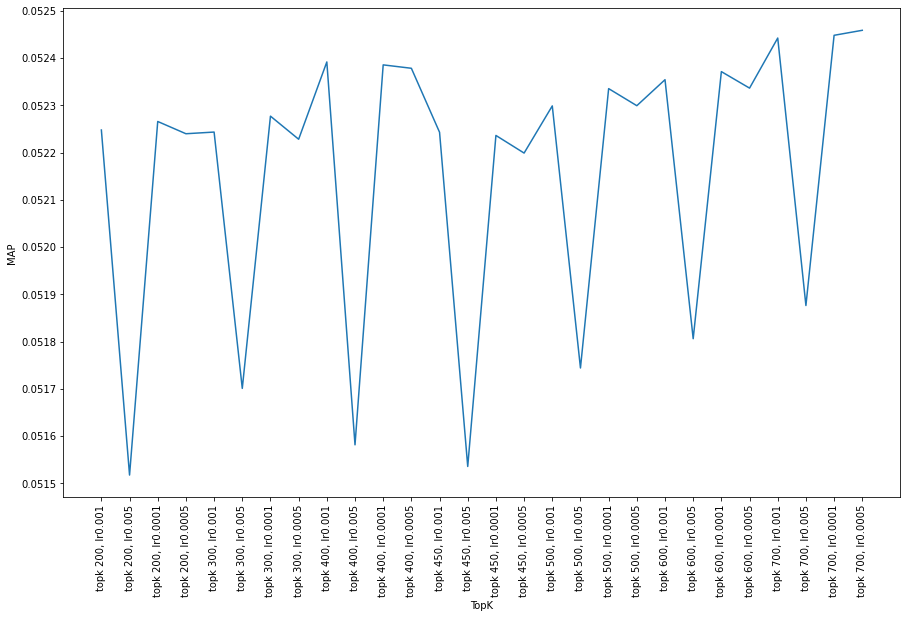

In [44]:
#best model: topk=700, lr = 0.0001. MAP = 0.0536, sgd_mode = adagrad.
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [45]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [46]:
recommender = SLIM_BPR_Cython(URM_all, recompile_cython=False)
#remember to specify the positive threshold
recommender.fit(epochs=200, batch_size=1000, sgd_mode='adagrad', learning_rate=0.001, positive_threshold_BPR=1, topK=400)
user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


SLIM_BPR_Recommender: URM Detected 1079 (4.15 %) cold items.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.15 seconds. BPR loss is 5.57E-08. Sample per second: 51615
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.02 sec
Processed 7947 ( 100.00% ) in 0.19 seconds. BPR loss is 2.19E-07. Sample per second: 41835
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.06 sec
Processed 7947 ( 100.00% ) in 0.22 seconds. BPR loss is 3.99E-07. Sample per second: 36136
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.09 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 5.18E-07. Sample per second: 31548
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.12 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 6.72E-07. Sample per second: 27

SLIM_BPR_Recommender: Epoch 53 of 200. Elapsed time 1.85 sec
Processed 7947 ( 100.00% ) in 1.02 seconds. BPR loss is 9.15E-06. Sample per second: 7813
SLIM_BPR_Recommender: Epoch 54 of 200. Elapsed time 1.89 sec
Processed 7947 ( 100.00% ) in 0.05 seconds. BPR loss is 9.34E-06. Sample per second: 171717
SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 1.92 sec
Processed 7947 ( 100.00% ) in 0.09 seconds. BPR loss is 9.98E-06. Sample per second: 92139
SLIM_BPR_Recommender: Epoch 56 of 200. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.12 seconds. BPR loss is 1.00E-05. Sample per second: 68364
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 1.99 sec
Processed 7947 ( 100.00% ) in 0.14 seconds. BPR loss is 9.76E-06. Sample per second: 56277
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 2.01 sec
Processed 7947 ( 100.00% ) in 0.17 seconds. BPR loss is 1.07E-05. Sample per second: 46694
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 2.04 sec
Processed 7947 ( 100.00% ) 

SLIM_BPR_Recommender: Epoch 107 of 200. Elapsed time 3.45 sec
Processed 7947 ( 100.00% ) in 0.62 seconds. BPR loss is 2.00E-05. Sample per second: 12852
SLIM_BPR_Recommender: Epoch 108 of 200. Elapsed time 3.49 sec
Processed 7947 ( 100.00% ) in 0.65 seconds. BPR loss is 2.03E-05. Sample per second: 12145
SLIM_BPR_Recommender: Epoch 109 of 200. Elapsed time 3.52 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 1.94E-05. Sample per second: 11496
SLIM_BPR_Recommender: Epoch 110 of 200. Elapsed time 3.56 sec
Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 2.03E-05. Sample per second: 10988
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 3.59 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 2.07E-05. Sample per second: 10550
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 3.62 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 2.07E-05. Sample per second: 10160
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 3.65 sec
Processed 7947 ( 100

SLIM_BPR_Recommender: Epoch 161 of 200. Elapsed time 5.04 sec
Processed 7947 ( 100.00% ) in 0.20 seconds. BPR loss is 2.94E-05. Sample per second: 40165
SLIM_BPR_Recommender: Epoch 162 of 200. Elapsed time 5.07 sec
Processed 7947 ( 100.00% ) in 0.23 seconds. BPR loss is 2.91E-05. Sample per second: 35188
SLIM_BPR_Recommender: Epoch 163 of 200. Elapsed time 5.10 sec
Processed 7947 ( 100.00% ) in 0.25 seconds. BPR loss is 3.05E-05. Sample per second: 31311
SLIM_BPR_Recommender: Epoch 164 of 200. Elapsed time 5.12 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 2.95E-05. Sample per second: 28301
SLIM_BPR_Recommender: Epoch 165 of 200. Elapsed time 5.15 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 3.07E-05. Sample per second: 26074
SLIM_BPR_Recommender: Epoch 166 of 200. Elapsed time 5.17 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 3.17E-05. Sample per second: 24026
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 5.20 sec
Processed 7947 ( 100

In [47]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [48]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
